<center><b><font size="5">Towards a fitting procedure for deeply virtual Compton scattering at next-to-leading order and beyond</font></b></center><br>
This is the jupyter/python code that reproduces some figures from paper by K. Kumericki, D. Mueller and K. Passek-Kumericki, <i>Towards a fitting procedure for deeply virtual Compton scattering at next-to-leading order and beyond</i>, published in Nuclear Physics <b>B794</b> 244-323 (2008) [arXiv:<a href='https://arxiv.org/abs/hep-ph/0703179'>hep-ph/0703179</a>].

Figures for the published paper were produced by older Fortan version of the same code. They also contain NNLO curves, but Python Gepard package have only NLO implemented at the moment.

# Intro

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import gepard as g
print(g.__version__)

0.9.9


GPD ansatz is actually implemented in the Gepard package, so we
only need to override some defaults:

In [3]:
class MyTheory(g.ConformalSpaceGPD, g.MellinBarnesCFF):
    """GPD/CFF model from the paper - singlet and nonsinglet part."""
    
    def __init__(self, type, **kwargs) -> None:
        # defaults from old Fortran's GEPARD.INI
        kwargs.setdefault('p', 1)
        kwargs.setdefault('scheme', 'csbar')
        kwargs.setdefault('nf', 4)
        kwargs.setdefault('Q02', 2.5)
        kwargs.setdefault('asp', np.array([0.05, 0.05, 0.05]))
        kwargs.setdefault('phi', 1.9)
        self.type = type
        super().__init__(**kwargs)
        R = 0.5  # ratio sbar/ubar
        self.frot = np.array([[1, 0, 1, 1],                                                                                                     
                               [0, 1, 0, 0],                                                                                                                                                                                                      
                               [-R/(2+R), 0, 1, -1]])

    def H(self, eta: float, t: float) -> np.ndarray:
        return g.gpd.ansatz07_fixed(self.jpoints, t, self.type).transpose()

# Figure 7

In [4]:
models = {}
for p in [0, 1]:
    for scheme in ['csbar', 'msbar']:
        for type in ['hardNS', 'softNS']:
            th = MyTheory(type, p=p, scheme=scheme)
            qs = 5/18
            qns = 1/6  # for nf=4
            th.dvcs_charges = (0, 0, qns)  # we plot only NS part of CFF
            models[(p, scheme, type)] = th

In [5]:
pt = g.data.DataPoint({'xi': 0.01, 'Q2': 2.5, 't': -0})

In [6]:
m0 = models[(0, 'csbar', 'softNS')]
m1 = models[(1, 'csbar', 'softNS')]

In [7]:
print(f'{m0.ReH(pt)} + {m0.ImH(pt)}j')

-4.697562405820484 + 6.72274551033928j


In [8]:
print(f'{m1.ReH(pt)} + {m1.ImH(pt)}j')

-3.919752527343703 + 5.955404052386994j


In [9]:
100* (abs(m1.ReH(pt) + m1.ImH(pt)*1j)/abs(m0.ReH(pt) + m0.ImH(pt)*1j) -1 )

-13.068050708649203

In [10]:
# radNLONS.f
100*(abs(-3.9197525273577596+5.9554040524086158j)/abs(-4.6975624058203884+6.7227455103392737j)-1)

-13.068050708334123

In [11]:
def del1K(xi, t, scheme, type):
    pt = g.data.DataPoint({'xi': xi, 'Q2': 2.5, 't': t})
    Habs = {}
    for p in [0, 1]:
        m = models[(p, scheme, type)]
        # print(f'{p} -> {m.ReH(pt)} + {m.ImH(pt)}j')
        Habs[p] = np.sqrt(m.ReH(pt)**2 + m.ImH(pt)**2)
    return 100*(Habs[1]/Habs[0] - 1)

In [12]:
xis = [0.01, 0.5]
for scheme in ['csbar', 'msbar']:
    for type in ['hardNS', 'softNS']:
        for xi in xis:
            print(f'{scheme}, {type}, {xi} -> {del1K(xi, 0, scheme, type):.7}')

csbar, hardNS, 0.01 -> -6.173006
csbar, hardNS, 0.5 -> 2.897109
csbar, softNS, 0.01 -> -13.06805
csbar, softNS, 0.5 -> -1.912848
msbar, hardNS, 0.01 -> -13.39226
msbar, hardNS, 0.5 -> -6.162382
msbar, softNS, 0.01 -> -18.62158
msbar, softNS, 0.5 -> -10.31256


In [13]:
##  Output of radNLONS.f.
# -6.1730062
#  2.8971091
# -13.0680507
# -1.9128482
# -13.3922583
#  -6.1623820
# -18.6215834
# -10.3125565

In [14]:
xis = np.linspace(0.01, 0.5)

In [15]:
Ks = {}
for scheme in ['csbar', 'msbar']:
    for type in ['hardNS', 'softNS']:
        for t in [0, -1]:
            Ks[(scheme, type, t)] = []
            for xi in xis:
                Ks[(scheme, type, t)].append(del1K(xi, t, scheme, type))

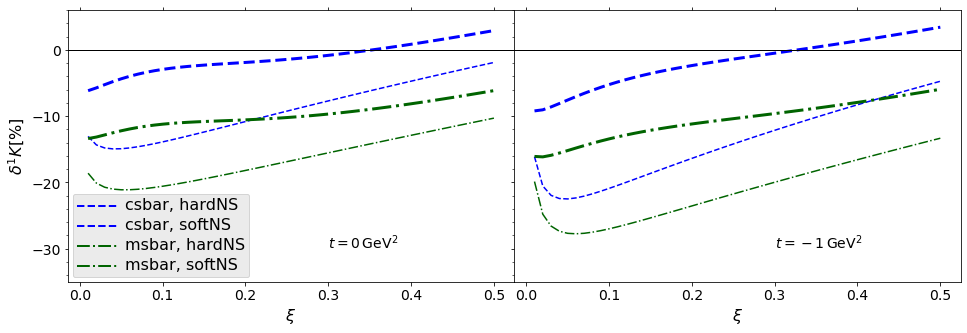

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(16,5), sharey=True)
lstyle = {('csbar', 'hardNS') : (3, 'blue', '--'),
          ('csbar', 'softNS') : (1.5, 'blue', '--'),
          ('msbar', 'hardNS') : (3, 'darkgreen', '-.'),
          ('msbar', 'softNS') : (1.5, 'darkgreen', '-.')}
for pn, ax in enumerate(axs):
    t = {0: 0, 1: -1}[pn]
    for scheme in ['csbar', 'msbar']:
        for type in ['hardNS', 'softNS']:
            width, color, style = lstyle[(scheme, type)]
            ax.plot(xis, Ks[(scheme, type, t)],
                    lw=width, ls=style, color=color, label=f'{scheme}, {type}')
    # ax.set_xscale('log')
    ax.set_xlabel(r'$\xi$', fontsize=16)
    ax.set_ylim(-35, 6)
    ax.text(0.3, -30, r'$t={}\, \mathrm{{GeV}}^2$'.format(t), fontsize=14)
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10))
    ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(2))
    ax.tick_params(axis='both', which='major', labelsize=14, top=True)
    ax.axhline(y=0, linewidth=1, color='k')  # y=0 thin line
    if pn == 0:
        ax.set_ylabel(r'$\delta^1 K [\%]$', fontsize=16)  
        leg = ax.legend(handlelength=4, fancybox=True)
        frame  = leg.get_frame()                                                          
        frame.set_facecolor('0.90')     
        for t in leg.get_texts():                                                         
            t.set_fontsize(16)                             
        for l in leg.get_lines():                                                         
            l.set_linewidth(2.0) 
fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.canvas.draw()

# Figure 8

In [17]:
def DeltaK(xi, Q2, p, scheme, type):
    Habs = {}
    for qq in [2.5, Q2]:
        m = models[(p, scheme, type)]
        pt = g.data.DataPoint({'xi': xi, 'Q2': qq, 't': -0.25})
        # print(f'{p} -> {m.ReH(pt)} + {m.ImH(pt)}j')
        Habs[qq] = np.sqrt(m.ReH(pt)**2 + m.ImH(pt)**2)
    return 100*(Habs[Q2]/Habs[2.5] - 1)

In [18]:
pt0 = g.data.DataPoint({'xi': 0.01, 'Q2': 2.5, 't': -0.25})
pt = g.data.DataPoint({'xi': 0.01, 'Q2': 10, 't': -0.25})

In [19]:
m = models[(0, 'csbar', 'softNS')]

In [20]:
print(f'{m.ReH(pt0)} + {m.ImH(pt0)}j')
print(f'{m.ReH(pt)} + {m.ImH(pt)}j')

-3.199064990205347 + 2.831107639166143j
-3.3434664575694475 + 3.2746037702606183j


In [21]:
100* (abs(m.ReH(pt) + m.ImH(pt)*1j)/abs(m.ReH(pt0) + m.ImH(pt0)*1j) -1 )

9.551447092903654

In [22]:
# evolutNS.F
# LO, softNS
# Q02 = 2.5   (-3.1990649836909397,2.8311076329681879)
# Q2 = 10      (-3.3434664508535761,3.2746037631722760)

In [23]:
m = models[(1, 'csbar', 'softNS')]

In [24]:
print(f'{m.ReH(pt0)} + {m.ImH(pt0)}j')
print(f'{m.ReH(pt)} + {m.ImH(pt)}j')

-2.5994805316096503 + 2.5457462292785067j
-2.880950287724593 + 3.0963811206353107j


In [25]:
100* (abs(m.ReH(pt) + m.ImH(pt)*1j)/abs(m.ReH(pt0) + m.ImH(pt0)*1j) -1 )

16.24145018970353

In [26]:
# evolutNS.F
# NLO,  csbar softNS
# Q02 = 2.5   (-2.5994805263362908,2.5457462238353576)
# Q2 = 10     (-2.8809502819615407,3.0963811140531412)

In [27]:
m = models[(1, 'msbar', 'softNS')]

In [28]:
print(f'{m.ReH(pt0)} + {m.ImH(pt0)}j')
print(f'{m.ReH(pt)} + {m.ImH(pt)}j')

-2.41988991509234 + 2.423455046443768j
-2.7411530915882145 + 2.9983776620916016j


In [29]:
100* (abs(m.ReH(pt) + m.ImH(pt)*1j)/abs(m.ReH(pt0) + m.ImH(pt0)*1j) -1 )

18.62236283271086

In [30]:
# evolutNS.F with MSBDI scheme
# NLO,  msbar softNS
# Q02 = 2.5   (-2.4198899101889770,2.4234550412655573)
# Q2 = 10     (-2.7331502789179858,2.9822723014486789)
100* (abs(-2.7331502789179858 + 2.9822723014486789*1j)/abs(-2.4198899101889770 +2.4234550412655573*1j) -1 )

18.11770248222746

In [31]:
xis = [0.01, 0.5]
for p, scheme in [(0, 'csbar'), (1, 'csbar'), (1, 'msbar')]:
    for type in ['hardNS', 'softNS']:
        for xi in xis:
            print(f'{p}, {scheme}, {type}, {xi} -> {DeltaK(xi, 10, p, scheme, type):.7}')

0, csbar, hardNS, 0.01 -> -3.342846
0, csbar, hardNS, 0.5 -> -9.870049
0, csbar, softNS, 0.01 -> 9.551447
0, csbar, softNS, 0.5 -> -7.424773
1, csbar, hardNS, 0.01 -> -2.521452
1, csbar, hardNS, 0.5 -> -12.94002
1, csbar, softNS, 0.01 -> 16.24145
1, csbar, softNS, 0.5 -> -8.021809
1, msbar, hardNS, 0.01 -> -0.5478313
1, msbar, hardNS, 0.5 -> -11.37569
1, msbar, softNS, 0.01 -> 18.62236
1, msbar, softNS, 0.5 -> -6.114712


In [32]:
## output of evolutNS.f, with MSBDI -> MSBAR (file evolutNS1.dat)
# -3.3428462
# -9.8700490
#  9.5514471
# -7.4247729
# -2.5214520
# -12.9400189
#  16.2414502
#  -8.0218087
#  -0.5478529
# -11.3784001
#  18.6223331
#  -6.1174170

In [33]:
xis = np.linspace(0.05, 0.5)

In [34]:
Ks = {}
for p, scheme in [(0, 'csbar'), (1, 'csbar'), (1, 'msbar')]:
    for type in ['hardNS', 'softNS']:
        for Q2 in [1, 10]:
            Ks[(p, scheme, type, Q2)] = []
            for xi in xis:
                Ks[(p, scheme, type, Q2)].append(DeltaK(xi, Q2, p, scheme, type))

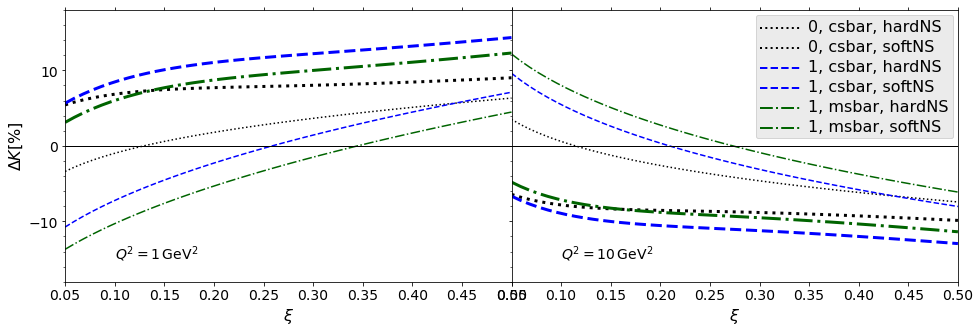

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(16,5), sharey=True)
lstyle = {(0, 'csbar', 'hardNS') : (3, 'black', ':'),
          (0, 'csbar', 'softNS') : (1.5, 'black', ':'),
          (1, 'csbar', 'hardNS') : (3, 'blue', '--'),
          (1, 'csbar', 'softNS') : (1.5, 'blue', '--'),
          (1, 'msbar', 'hardNS') : (3, 'darkgreen', '-.'),
          (1, 'msbar', 'softNS') : (1.5, 'darkgreen', '-.')}
for pn, ax in enumerate(axs):
    Q2 = {0: 1, 1: 10}[pn]
    for p, scheme in [(0, 'csbar'), (1, 'csbar'), (1, 'msbar')]:
        for type in ['hardNS', 'softNS']:
            width, color, style = lstyle[(p, scheme, type)]
            ax.plot(xis, Ks[(p, scheme, type, Q2)],
                    lw=width, ls=style, color=color, label=f'{p}, {scheme}, {type}')
    ax.set_xlabel(r'$\xi$', fontsize=16)
    ax.text(0.1, -15, r'$Q^2={}\, \mathrm{{GeV}}^2$'.format(Q2), fontsize=14)

    ax.tick_params(axis='both', which='major', labelsize=14, top=True)
    ax.set_xlim(0.05, 0.5)
    ax.set_ylim(-18, 18)
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10))
    ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(2))
    ax.axhline(y=0, linewidth=1, color='k')  # y=0 thin line
    if pn == 0:
        ax.set_ylabel(r'$\Delta K [\%]$', fontsize=16)        
    elif pn == 1:
        leg = ax.legend(loc=0, handlelength=4, fancybox=True)
        frame  = leg.get_frame()                                                          
        frame.set_facecolor('0.90')     
        for t in leg.get_texts():                                                         
            t.set_fontsize(16)                             
        for l in leg.get_lines():                                                         
            l.set_linewidth(2.0)
fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.canvas.draw()

# Figure 9

In [36]:
models = {}
for p in [0, 1]:
    for scheme in ['csbar', 'msbar']:
        for type in ['hard', 'soft']:
            th = MyTheory(type, p=p, scheme=scheme)
            qs = 5/18
            qns = 1/6  # for nf=4
            th.dvcs_charges = (qs, qs, 0)  # we plot only singlet part of CFF
            models[(p, scheme, type)] = th

In [37]:
pt = g.data.DataPoint({'xi': 1.e-5, 'Q2': 2.5, 't': 0})
m0 = models[(0, 'csbar', 'soft')]
m1 = models[(1, 'csbar', 'soft')]

In [38]:
print(f'{m1.ReH(pt)} + {m1.ImH(pt)}j')

146161.81949223322 + 889143.9291910823j


In [39]:
print(f'{m0.ReH(pt)} + {m0.ImH(pt)}j')

151592.89009351755 + 963826.4422642181j


In [40]:
100* (abs(m1.ReH(pt) + m1.ImH(pt)*1j)/abs(m0.ReH(pt) + m0.ImH(pt)*1j) -1 )

-7.645763728129273

In [41]:
# radNLO.F numbers
100*(abs(146161.81949266847+889143.92919388134j)/abs(151592.89009351653+963826.44226421416j)-1)

-7.6457637278385615

In [42]:
def del1K(xi, t, scheme, type):
    pt = g.data.DataPoint({'xi': xi, 'Q2': 2.5, 't': t})
    Habs = {}
    for p in [0, 1]:
        m = models[(p, scheme, type)]
        # print(f'{p} -> {m.ReH(pt)} + {m.ImH(pt)}j')
        Habs[p] = np.sqrt(m.ReH(pt)**2 + m.ImH(pt)**2)
    return 100*(Habs[1]/Habs[0] - 1)

In [43]:
xis = [1e-5, 0.5]
for scheme in ['csbar', 'msbar']:
    for type in ['hard', 'soft']:
        for xi in xis:
            print(f'{scheme}, {type}, {xi} -> {del1K(xi, 0, scheme, type):.7}')

csbar, hard, 1e-05 -> -47.50468
csbar, hard, 0.5 -> -12.27331
csbar, soft, 1e-05 -> -7.645764
csbar, soft, 0.5 -> -7.334354
msbar, hard, 1e-05 -> -62.36607
msbar, hard, 0.5 -> -23.10067
msbar, soft, 1e-05 -> -14.93422
msbar, soft, 0.5 -> -17.38892


In [44]:
## Numbers by radcorr.f (which was used to produce the Fig. 1):
# -47.5046753
# -12.2733093
# -7.6457637
# -7.3343536
# -62.3660662
# -23.1006672
# -14.9342243
# -17.3889222

In [45]:
xis = np.logspace(-5, -0.30103)

In [46]:
Ks = {}
for scheme in ['csbar', 'msbar']:
    for type in ['hard', 'soft']:
        for t in [0, -1]:
            Ks[(scheme, type, t)] = []
            for xi in xis:
                Ks[(scheme, type, t)].append(del1K(xi, t, scheme, type))

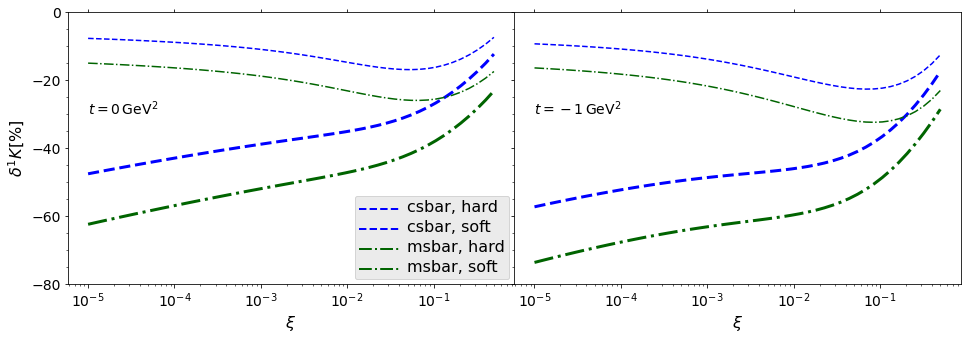

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(16,5), sharey=True)
lstyle = {('csbar', 'hard') : (3, 'blue', '--'),
          ('csbar', 'soft') : (1.5, 'blue', '--'),
          ('msbar', 'hard') : (3, 'darkgreen', '-.'),
          ('msbar', 'soft') : (1.5, 'darkgreen', '-.')}
for pn, ax in enumerate(axs):
    t = {0: 0, 1: -1}[pn]
    for scheme in ['csbar', 'msbar']:
        for type in ['hard', 'soft']:
            width, color, style = lstyle[(scheme, type)]
            ax.plot(xis, Ks[(scheme, type, t)],
                    lw=width, ls=style, color=color, label=f'{scheme}, {type}')
    ax.set_xscale('log')
    ax.set_xlabel(r'$\xi$', fontsize=16)
    ax.set_ylim(-80, 0)
    ax.text(1.e-5, -30, r'$t={}\, \mathrm{{GeV}}^2$'.format(t), fontsize=14)
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(20))
    ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(5))
    ax.tick_params(axis='both', which='major', labelsize=14, top=True)
    if pn == 0:
        ax.set_ylabel(r'$\delta^1 K [\%]$', fontsize=16)  
        leg = ax.legend(handlelength=4, fancybox=True)
        frame  = leg.get_frame()                                                          
        frame.set_facecolor('0.90')     
        for t in leg.get_texts():                                                         
            t.set_fontsize(16)                             
        for l in leg.get_lines():                                                         
            l.set_linewidth(2.0) 
fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.canvas.draw()

# Figure 10

In [48]:
def DeltaK(xi, Q2, p, scheme, type):
    Habs = {}
    for qq in [2.5, Q2]:
        m = models[(p, scheme, type)]
        pt = g.data.DataPoint({'xi': xi, 'Q2': qq, 't': -0.25})
        # print(f'{p} -> {m.ReH(pt)} + {m.ImH(pt)}j')
        Habs[qq] = np.sqrt(m.ReH(pt)**2 + m.ImH(pt)**2)
    return 100*(Habs[Q2]/Habs[2.5] - 1)

In [49]:
xis = [1e-5, 0.5]
for p, scheme in [(0, 'csbar'), (1, 'csbar'), (1, 'msbar')]:
    for type in ['hard', 'soft']:
        for xi in xis:
            print(f'{p}, {scheme}, {type}, {xi} -> {DeltaK(xi, 5, p, scheme, type):.7}')

0, csbar, hard, 1e-05 -> 24.88091
0, csbar, hard, 0.5 -> -1.338735
0, csbar, soft, 1e-05 -> 4.955807
0, csbar, soft, 0.5 -> -2.422441
1, csbar, hard, 1e-05 -> 37.65687
1, csbar, hard, 0.5 -> 0.5706388
1, csbar, soft, 1e-05 -> 0.3260295
1, csbar, soft, 0.5 -> -1.817129
1, msbar, hard, 1e-05 -> 59.09932
1, msbar, hard, 0.5 -> 2.787284
1, msbar, soft, 1e-05 -> 1.396946
1, msbar, soft, 0.5 -> -0.1006238


In [50]:
## Numbers by ND-fixed radcorr.f:
# 24.8809148
# -1.3387345
# 4.9558075
# -2.4224412
# 37.6568659
#  0.5706389
# 0.3260295
# -1.8171292
# 59.0999142
# 2.7845798
#  1.3970653
# -0.1027154

In [51]:
## Numbers by ND-buggy-factorized-R radcorr.f (which was used to produce the Fig. 10):
# 24.8809148
# -1.3387345
# 4.9558075
# -2.4224412
# 37.6568659
# 0.5706389
# 0.3260295
# -1.8171292
# 56.6980953
# 2.7352502
# 1.0056914
# -0.1494166

In [52]:
xis = np.logspace(-5, -0.30103)

In [53]:
Ks = {}
for p, scheme in [(0, 'csbar'), (1, 'csbar'), (1, 'msbar')]:
    for type in ['hard', 'soft']:
        for Q2 in [5, 25]:
            Ks[(p, scheme, type, Q2)] = []
            for xi in xis:
                Ks[(p, scheme, type, Q2)].append(DeltaK(xi, Q2, p, scheme, type))

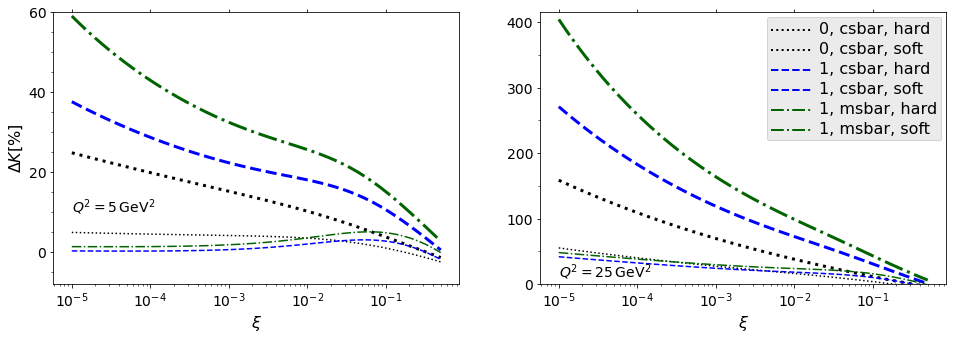

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(16,5), sharey=False)
lstyle = {(0, 'csbar', 'hard') : (3, 'black', ':'),
          (0, 'csbar', 'soft') : (1.5, 'black', ':'),
          (1, 'csbar', 'hard') : (3, 'blue', '--'),
          (1, 'csbar', 'soft') : (1.5, 'blue', '--'),
          (1, 'msbar', 'hard') : (3, 'darkgreen', '-.'),
          (1, 'msbar', 'soft') : (1.5, 'darkgreen', '-.')}
for pn, ax in enumerate(axs):
    Q2 = {0: 5, 1: 25}[pn]
    for p, scheme in [(0, 'csbar'), (1, 'csbar'), (1, 'msbar')]:
        for type in ['hard', 'soft']:
            width, color, style = lstyle[(p, scheme, type)]
            ax.plot(xis, Ks[(p, scheme, type, Q2)],
                    lw=width, ls=style, color=color, label=f'{p}, {scheme}, {type}')
    ax.set_xscale('log')
    ax.set_xlabel(r'$\xi$', fontsize=16)
    ax.text(1.e-5, 10, r'$Q^2={}\, \mathrm{{GeV}}^2$'.format(Q2), fontsize=14)

    ax.tick_params(axis='both', which='major', labelsize=14, top=True)
    if pn == 0:
        ax.set_ylim(-8, 60)
        ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(20))
        ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(5))
        ax.set_ylabel(r'$\Delta K [\%]$', fontsize=16)        
    elif pn == 1:
        ax.set_ylim(0, 415)
        ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(100))
        ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(50))
        leg = ax.legend(handlelength=4, fancybox=True)
        frame  = leg.get_frame()                                                          
        frame.set_facecolor('0.90')     
        for t in leg.get_texts():                                                         
            t.set_fontsize(16)                             
        for l in leg.get_lines():                                                         
            l.set_linewidth(2.0)
#fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.canvas.draw()

# Fits

In [55]:
DISpoints = g.dset[201].copy()                                                                                                               
for id in range(202, 213):                                                                                                                        
    DISpoints += g.dset[id]
len(DISpoints)   # 85 points used in paper

85

In [56]:
DVCSpoints = g.dset[39]+g.dset[43]+g.dset[44]+g.dset[45]+g.dset[24]
len (DVCSpoints)  # 39 points used in paper

39

Note that for fitting we have to add code which calculates DIS F2 and DVCS cross sections (BMK), so we inherit also from ``g.DIS`` and  ``g.BMK``:

In [57]:
class MyTheory(g.ConformalSpaceGPD, g.MellinBarnesCFF, g.DIS, g.BMK):
    """Model for fits in the paper - singlet GPDs only."""
    
    def __init__(self, **kwargs) -> None:
        # defaults from old Fortran's GEPARD.INI
        kwargs.setdefault('p', 0)
        kwargs.setdefault('scheme', 'csbar')
        kwargs.setdefault('nf', 4)
        kwargs.setdefault('phi', 1.9)
        super().__init__(**kwargs)
        self.frot = np.array([[1, 0, 0, 0],                                                                                                     
                              [0, 1, 0, 0],                                                                                                                                                                                                      
                              [0, 0, 0, 0]])

    def H(self, eta: float, t: float) -> np.ndarray:
        return g.gpd.ansatz07(self.jpoints, t, self.parameters).transpose()

In [58]:
th = MyTheory()

In [59]:
MP = 0.938272 # proton mass                                                                                                                     
par_bp_fit = {'ns': 0.1157, 'al0s': 1.17, 'alps': 0.15,                                                                                                   
             'ms2': 0.228, 'delms2': 0, 'pows': 3,                                                                                        
               'ng': 0.527, 'al0g': 1.25, 'alpg': 0.15,                                                                                              
               'mg2': 0.263, 'delmg2': 0, 'powg': 2,                                                                                        
               'nu': 0.0, 'al0u': 0.5, 'alpu': 1.0,                                                                                               
               'mu2': (2*MP)**2, 'delmu2': MP**2, 'powu': 1,                                                                                        
               'nd': 0.0, 'al0d': 0.5, 'alpd': 1.0,                                                                                               
               'md2': (2*MP)**2, 'delmd2': MP**2, 'powd': 1}

In [60]:
th.parameters.update(par_bp_fit)

In [61]:
th.chisq(DISpoints+DVCSpoints)  # Initially fit is terrible 806./124

806.115499344836

In [62]:
f = g.MinuitFitter(fitpoints=(DISpoints+DVCSpoints), theory=th)

In [63]:
f.fix_parameters('ALL')

In [64]:
f.release_parameters('ns', 'al0s', 'ms2', 'ng', 'al0g', 'mg2')

In [65]:
f.limit_parameters({'ms2': (0, 100)})
f.limit_parameters({'mg2': (0, 100)})

In [66]:
%%time
f.fit()

CPU times: user 16 s, sys: 6.39 ms, total: 16 s
Wall time: 16 s


In [67]:
f.print_parameters()  # To print only free fitting parameters

ns    =    0.139 +- 0.008
al0s  =    1.194 +- 0.012
ms2   =    0.194 +- 0.015
ng    =    0.657 +- 0.050
al0g  =    1.162 +- 0.027
mg2   =    0.316 +- 0.073


Fit is statistically OK looking at overal $\chi^2$ only ... 

In [68]:
f.minuit.fval, len(f.fitpoints)  # 

(95.3275727920793, 124)

... but $t$-dependence is badly described:

In [69]:
th.chisq(g.dset[39]), len(g.dset[39])

(42.38148583321684, 8)

Note that in the published paper (Table 4), we have slightly different values for
$\chi^2$, 100 overall and 38.5 for t-dependent part.

Note: Presently I cannot get NLO fits as in the published paper.
This should be investigated at some point. (Note that NLO fits are fine
in notebook `npb09.ipynb` reproducing later paper.)